#  Install package

In [277]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install dash

# Import package

In [278]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai


# Define Solution class
Please run the following cell to define the functions

In [279]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [280]:
# Case 1: population living near hazardous wastes

TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]


task_name ='Resident_at_risk_counting'


# Case 2: mobility data retrieval and visulization
"""
TASK = r'''
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip." + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code, France administrative regions start with 'FRA'.",
                 ]


# task_name ='France_mobility_changes_2020'
"""

# Case 3: Provider address extraction
# TASK = r"""1) Find out the Autism service providers' addresses or location from their website. The address usually listed in the homepage, 'about' or 'contact' page. The latter two pages usually contain 'about' or 'contact' in links embedded in the homepage.
# 2) A provider may have multiple service address. If cannot find the address, simply return an empty text, DO NOT make up fake addresses. 
# 3) You need to send webpage text ChatGPT to extract address. Use this pre-written function your designed detailed prompt to get response from ChatGPT: helper.get_LLM_reply(prompt=your_prompt_with_webpage_text, model=r"gpt-4",). Use this statement to extract content from the returned response: response['choices'][0]['message']['content']. Let ChatGPT reply in json format as {'address': extracted_address}.  DO NOT reuturn explaination or conversation, return the address or empty text only. 
# 4) Save the extracted addresses as "Address" column, together with the given 'Provider' and 'Web Site' columns. If there are multile addresses for a provider, each address is a row in the CSV file.
# """

# DATA_LOCATIONS = ["Autism service provider webpage file location: E:\Research\LLM-Geo\Address_extraction\ACE_providers_AGIS.csv. The 'Web Site' column is the URL, the 'Provider' column is the provider name.",                  
#                  ]

# task_name ='Address_extraction'


"""
# Case 3: COVID-19 prevalence trend
TASK = r'''1) Draw a line chart to show the daily accumulated COVID-19 cases in 2021 in the US, each state each line.
2) Draw a bar chart to show the total COVID-19 deaths in each state, sorted from high to low.
3) Draw a scatter plot to show the relationship between total cases and total deaths in 2021. Each county is an observation. Show the regression line in the scatter plot.
For all figures and maps, use figure size (25,15).
'''

DATA_LOCATIONS = [
                  r"COVID-19 data case in 2021 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2021.csv. This data is for daily accumulated COVID cases for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
                 ]

"""

"""
# Case 4: COVID-19 prevalence mapping (Testing, not ready yet)
TASK = r'''1) Draw a map matrix of South Carolina counties' monthly COVID-19 infection ratio in 2021. Each month is a submap.
2) county infection ratio = (infection of this month / county popultion).
'''

DATA_LOCATIONS = [r"South Carolina county boudary, ESRI shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/COVID-19/SC_counties.zip. ",
                  r"COVID-19 data case in 2021 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2021.csv. It is a CSV file; there are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",                  
                  r"Population data: use Python library CensusData to obtain data. ",
                 ]
# API_DOC_LOCATION = [(1, r'https://raw.githubusercontent.com/gladcolor/LLM-Geo/master/COVID-19/CensusData_API_DOC.txt')] 
API_DOC_LOCATION = [(2, r'./COVID-19/CensusData_API_DOC.txt')] 
# [(Input_data_index, API_cocumentation_path)]


# add the API documentation to DATA_LOCATION
for idx, path in API_DOC_LOCATION:
    with open(path, 'r', encoding='utf-8') as f:
        docs = f.readlines()
    docs = '\n'.join(docs)

    DATA_LOCATIONS[idx] += "The documentation is: \n" + docs


# https://raw.githubusercontent.com/gladcolor/LLM-Geo/master/Address_extraction/ACE_providers_AGIS.csv

# TASK = r'''1)Retrieve the data from the REST API and plot the intra_movement column of the returned data as line chart to show the temporal trend of all states. 
# 2) plot the temporal trend of the movement for each state. Each state figure will be sub figure in the plot. The plot has 5 columns. In addition, please add a weekly smoothed line to each sub plot, and change the line color to orange.
# 3) Using the REST API with date range from 01/01/2020 to 12/31/2020 to analyze the movement reduction rate for each state during two periods: the first period is 01/01/2020-02/29/2020, second period is 03/01/2020 to 04/30/2020. Please find out the reduction rate for each state during the two periods, and create a table to report the result with two columns: state name, reduction rate, sorted by reduction rate.
# '''
# '''
# DATA_LOCATIONS = ["REST API url with parameters for data access: http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=us_state&begin=01/01/2020&end=12/31/2020; The response is in CSV format. There are three columns in the response: place,date,intra_movement; place refers to the state name."
#                  ]
# '''
# 3) Show the administrative region name in the map and chart.
#
# task_name ='COVID-19_infection_rate'
'''

"""

# Case 5: interactive visualization
#Example Source: https://artificialcorner.com/insanely-fast-data-storytelling-with-chatgpt-and-python-1bddae3976f3

task_name ='interactive_visualization'

TASK = r''' Use Plotly to create interactive map and charts.
1) Create a Plotly interactive map to show each country's average per capita CO2 emission between 1970 and 2020. 
2) Select the top 10 countries by total emissions between 1970 and 2020, then draw a stacked area chart using Plotly to show their annual trends between 1970 and 2020.
3) Select the top 10 countries by average per capita emission between 1970 and 2020, then draw a line chart using Plotly to show their annual trends between 1970 and 2020.
'''

DATA_LOCATIONS = [
                  r"CO2 emission CSV file: https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv. The needed columns are: 'Country' , 'Year', 'Total', and 'Per Capita'.",  
                  r"Country boundary ESRI Shapefile: https://github.com/gladcolor/LLM-Geo/raw/develop/interactive_visualization/world_countries.zip. The country name is in the 'name' attribute."
]

# The map project is EPSG:3857 althought not set.


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
  Use Plotly to create interactive map and charts.
1) Create a Plotly interactive map to show each country's average per capita CO2 emission between 1970 and 2020. 
2) Select the top 10 countries by total emissions between 1970 and 2020, then draw a stacked area chart using Plotly to show their annual trends between 1970 and 2020.
3) Select the top 10 countries by average per capita emission between 1970 and 2020, then draw a line chart using Plotly to show their annual trends between 1970 and 2020.
 
Your reply needs to meet these requirements: 
 1. Think step by step.
2. Steps and data (both input and output) form a graph stored in NetworkX. Disconnected components are NOT allowed.
3. Each step is a data process operation: the input can be

## Get graph code from GPT API

In [281]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()
print()
print("Code to generate solution graph: \n")
print(solution.code_for_graph)

Geting LLM reply...
Got LLM reply.

Code to generate solution graph: 

import networkx as nx

G = nx.DiGraph()

# Load CO2 emission CSV file
G.add_node("CO2_emission_csv_url", node_type="data", data_path="https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv", description="CO2 emission CSV file URL")
G.add_node("load_CO2_emission_csv", node_type="operation", description="Load CO2 emission CSV file")
G.add_edge("CO2_emission_csv_url", "load_CO2_emission_csv")

G.add_node("CO2_emission_dataframe", node_type="data", description="CO2 emission data in a DataFrame")
G.add_edge("load_CO2_emission_csv", "CO2_emission_dataframe")

# Load world countries shapefile
G.add_node("world_countries_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/develop/interactive_visualization/world_countries.zip", description="World countries shapefile URL")
G.add_node("load_world_countries_shp", node_type="operation", description="Load world countries shapefile")
G.add_edge("wo

## Execute code to generate the solution graphto generate the solution graph

In [282]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\interactive_visualization.html


## Generate prompts and code for operations (functions)

In [283]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

# all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print("All operation code: \n")
# print(all_operation_code_str)

1 / 8, load_CO2_emission_csv
Geting LLM reply...
Got LLM reply.
2 / 8, load_world_countries_shp
Geting LLM reply...
Got LLM reply.
3 / 8, calc_avg_per_capita_emission
Geting LLM reply...
Got LLM reply.
4 / 8, create_plotly_map
Geting LLM reply...
Got LLM reply.
5 / 8, select_top10_total_emissions
Geting LLM reply...
Got LLM reply.
6 / 8, create_stacked_area_chart
Geting LLM reply...
Got LLM reply.
7 / 8, select_top10_avg_per_capita
Geting LLM reply...
Got LLM reply.
8 / 8, create_line_chart
Geting LLM reply...
Got LLM reply.


In [284]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
print(all_operation_code_str)
exec(all_operation_code_str)


import pandas as pd

def load_CO2_emission_csv(CO2_emission_csv_url='https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv'):
    """
    Description: Load CO2 emission CSV file
    :param CO2_emission_csv_url: CO2 emission CSV file URL
    :return: CO2_emission_dataframe
    """
    CO2_emission_dataframe = pd.read_csv(CO2_emission_csv_url, usecols=['Country', 'Year', 'Total', 'Per Capita'])
    return CO2_emission_dataframe
import geopandas as gpd

def load_world_countries_shp(world_countries_shp_url='https://github.com/gladcolor/LLM-Geo/raw/develop/interactive_visualization/world_countries.zip'):
    """
    Load world countries shapefile
    
    Parameters:
    world_countries_shp_url (str): The URL of the world countries shapefile
    
    Returns:
    world_countries_gdf (geopandas.GeoDataFrame): GeoDataFrame containing world countries shapes and attributes
    """
    
    world_countries_gdf = gpd.read_file(world_countries_shp_url)
    return world_countries_gdf
import p

In [285]:
# ! pip install altair
# ! pip install panel

## Generate prompts and code for assembly program

In [286]:
assembly_LLM_response = solution.get_LLM_assembly_response()
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

# print("Assembly code: \n")
# print(solution.code_for_assembly)

Geting LLM reply...
Got LLM reply.
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def main():
    # Load data
    CO2_emission_dataframe = load_CO2_emission_csv()
    world_countries_gdf = load_world_countries_shp()

    # Task 1: Create a Plotly interactive map
    avg_per_capita_emission = calc_avg_per_capita_emission(CO2_emission_dataframe)
    plotly_map = create_plotly_map(world_countries_gdf, avg_per_capita_emission)
    plotly_map.show()

    # Task 2: Draw a stacked area chart
    top10_total_emissions = select_top10_total_emissions(CO2_emission_dataframe)
    stacked_area_chart = create_stacked_area_chart(top10_total_emissions)
    stacked_area_chart.show()

    # Task 3: Draw a line chart
    top10_avg_per_capita = select_top10_avg_per_capita(avg_per_capita_emission)
    line_chart = create_line_chart(top10_avg_per_capita, CO2_emission_dataframe)
    line_chart.show()

if __name__ == "__main__":
  

## Execute assembly code

In [287]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly
print(solution.code_for_assembly)

import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def main():
    # Load data
    CO2_emission_dataframe = load_CO2_emission_csv()
    world_countries_gdf = load_world_countries_shp()

    # Task 1: Create a Plotly interactive map
    avg_per_capita_emission = calc_avg_per_capita_emission(CO2_emission_dataframe)
    plotly_map = create_plotly_map(world_countries_gdf, avg_per_capita_emission)
    plotly_map.show()

    # Task 2: Draw a stacked area chart
    top10_total_emissions = select_top10_total_emissions(CO2_emission_dataframe)
    stacked_area_chart = create_stacked_area_chart(top10_total_emissions)
    stacked_area_chart.show()

    # Task 3: Draw a line chart
    top10_avg_per_capita = select_top10_avg_per_capita(avg_per_capita_emission)
    line_chart = create_line_chart(top10_avg_per_capita, CO2_emission_dataframe)
    line_chart.show()

if __name__ == "__main__":
    main()


In [288]:
print(all_code)

import pandas as pd

def load_CO2_emission_csv(CO2_emission_csv_url='https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv'):
    """
    Description: Load CO2 emission CSV file
    :param CO2_emission_csv_url: CO2 emission CSV file URL
    :return: CO2_emission_dataframe
    """
    CO2_emission_dataframe = pd.read_csv(CO2_emission_csv_url, usecols=['Country', 'Year', 'Total', 'Per Capita'])
    return CO2_emission_dataframe
import geopandas as gpd

def load_world_countries_shp(world_countries_shp_url='https://github.com/gladcolor/LLM-Geo/raw/develop/interactive_visualization/world_countries.zip'):
    """
    Load world countries shapefile
    
    Parameters:
    world_countries_shp_url (str): The URL of the world countries shapefile
    
    Returns:
    world_countries_gdf (geopandas.GeoDataFrame): GeoDataFrame containing world countries shapes and attributes
    """
    
    world_countries_gdf = gpd.read_file(world_countries_shp_url)
    return world_countries_gdf
import p

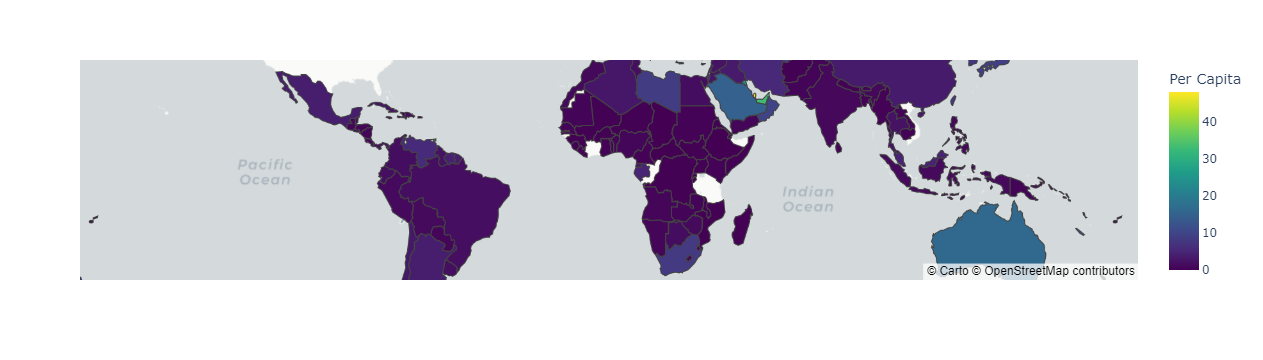

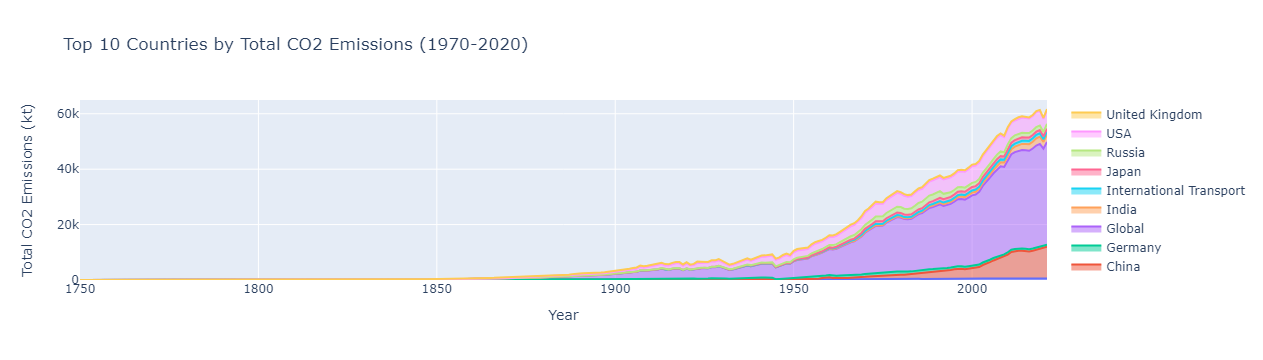

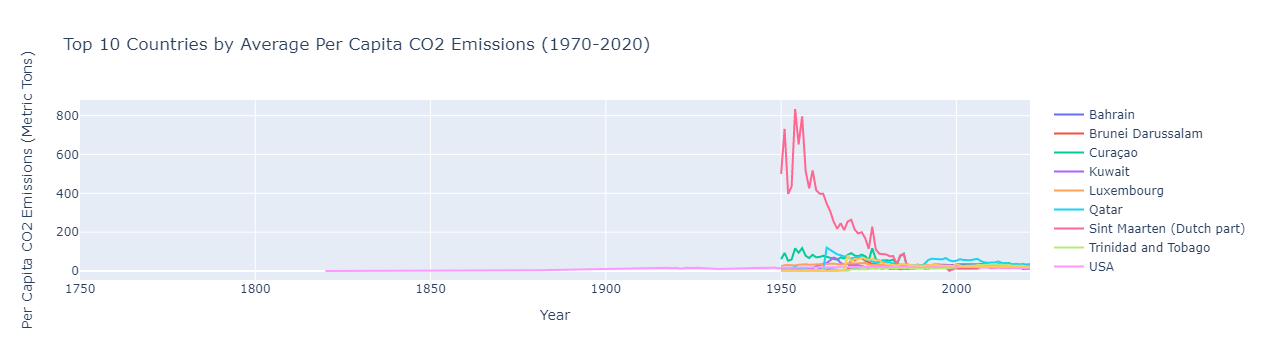

In [289]:
exec(all_code)

In [290]:
stop

NameError: name 'stop' is not defined